In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'C:\\Users\\clid1852\\.0GitHub\\BikeCounting\\BikeMap')
import ReviewData as RD
import pandas as pd
import geopandas as gpd
import pygeos
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
bikeFacilities = RD.readBikeFacility(add=False)

In [3]:
bikeFacilities.columns

Index(['name', 'type', 'lane_type', 'source', 'geom'], dtype='object')

In [4]:
bph = gpd.read_file(r"T:\MPO\Bike&Ped\BikeCounting\StoryMap\BikeCounts\Output\BPH_by_Year.shp")

In [5]:
bph = bph.to_crs(epsg=3857)

In [6]:
gpd.options.use_pygeos = True

In [7]:
spatial_join = gpd.sjoin_nearest(bph, bikeFacilities, distance_col="distances")

In [8]:
spatial_join.head()

,Locatin,Year,BPH,Latitud,Longitd,Site_Nm,DblCntL,IsOnewy,OnwyDrc,IsSdwlk,Growth,Nyrs,City,geometry,index_right,name,type,lane_type,source,distances
0,S32ndAccessPath,2016,0.147321,44.037466,-122.980292,Access Path between S 32nd Pl & S 32nd St,0,0,None,0,NaN,"2 (2016, 2019)",Springfield,POINT (-13690103.439 5471242.027),147,None,Bike Lane,None,LCOG,50.989781
1,S32ndAccessPath,2019,0.164957,44.037466,-122.980292,Access Path between S 32nd Pl & S 32nd St,0,0,None,0,0.039903,"2 (2016, 2019)",Springfield,POINT (-13690103.439 5471242.027),147,None,Bike Lane,None,LCOG,50.989781
2,YolandaEast23rd,2019,0.254958,44.072392,-122.990277,Yolanda Ave East of 23rd St,0,0,None,0,NaN,1 (2019),Springfield,POINT (-13691215.053 5476651.807),736,None,Bike Lane,None,LCOG,0.127209
3,WillametteSouth24thWestSidewalk,2017,0.338196,44.032808,-123.090711,Willamette St West Sidewalk South of 24th Pl,0,0,None,1,-0.781410,"4 (2014, 2015, 2016, 2017)",Eugene,POINT (-13702395.281 5470520.739),2782,None,Bike Lane,None,EUG,6.638764
73,WillametteSouth24thWestSidewalk,2016,1.547170,44.032808,-123.090711,Willamette St West Sidewalk South of 24th Pl,0,0,None,1,-0.645038,"4 (2014, 2015, 2016, 2017)",Eugene,POINT (-13702395.281 5470520.739),2782,None,Bike Lane,None,EUG,6.638764


In [9]:
spatial_join.columns

Index(['Locatin', 'Year', 'BPH', 'Latitud', 'Longitd', 'Site_Nm', 'DblCntL',
       'IsOnewy', 'OnwyDrc', 'IsSdwlk', 'Growth', 'Nyrs', 'City', 'geometry',
       'index_right', 'name', 'type', 'lane_type', 'source', 'distances'],
      dtype='object')

In [38]:
spatial_join['type'].unique()

array(['Bike Lane', 'Shared Use Path', 'Bike Route',
       'Connectivity for Routing', 'Paved Shoulder',
       'Pedestrian and Bicycle Access Way', 'Neighborhood Greenway'],
      dtype=object)

In [10]:
spatial_join.Year.min()

2012

In [11]:
spatial_join.Year.max()

2022

In [12]:
type(spatial_join)

geopandas.geodataframe.GeoDataFrame

In [13]:
print(spatial_join.crs)

epsg:3857


In [14]:
spatial_join.distances.describe()

count     810.000000
mean       79.546922
std       454.586139
min         0.041764
25%         0.997356
50%         1.647275
75%         6.267052
max      3899.681505
Name: distances, dtype: float64

<AxesSubplot:>

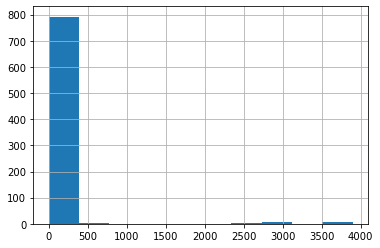

In [15]:
spatial_join.distances.hist()

In [16]:
spatial_join[spatial_join.distances <= 10][['BPH', 'type']].groupby('type').agg('mean')

,BPH
type,
Bike Lane,9.735967
Bike Route,9.467700
Neighborhood Greenway,11.223102
Pedestrian and Bicycle Access Way,9.571446
Shared Use Path,13.557319


In [17]:
spatial_join[spatial_join.distances > 10][['BPH', 'type']].groupby('type').agg('mean')

,BPH
type,
Bike Lane,5.718138
Bike Route,2.983007
Connectivity for Routing,1.118775
Neighborhood Greenway,6.295846
Paved Shoulder,2.320472
Pedestrian and Bicycle Access Way,3.400949
Shared Use Path,3.956107


In [18]:
spatial_join[['BPH', 'Locatin', 'type']].groupby('type').agg({"BPH": np.mean, "Locatin": pd.Series.nunique})

,BPH,Locatin
type,,
Bike Lane,9.308263,81
Bike Route,8.038004,29
Connectivity for Routing,1.118775,2
Neighborhood Greenway,10.445114,14
Paved Shoulder,2.320472,3
Pedestrian and Bicycle Access Way,7.103247,4
Shared Use Path,12.818765,50


In [19]:
spatial_join.columns

Index(['Locatin', 'Year', 'BPH', 'Latitud', 'Longitd', 'Site_Nm', 'DblCntL',
       'IsOnewy', 'OnwyDrc', 'IsSdwlk', 'Growth', 'Nyrs', 'City', 'geometry',
       'index_right', 'name', 'type', 'lane_type', 'source', 'distances'],
      dtype='object')

In [21]:
spatial_join.lane_type.unique()

array([None, 'Protected Bikeway', 'Shared Lane Marking',
       'Buffered Bike Lane'], dtype=object)

In [22]:
spatial_join[(spatial_join.distances <= 10) & (spatial_join['type'] == 'Bike Lane')][['BPH', 'lane_type']].groupby('lane_type').agg('mean')

,BPH
lane_type,
Buffered Bike Lane,14.048335
Protected Bikeway,18.868210


In [23]:
spatial_join[(spatial_join.distances <= 10)][['BPH', 'lane_type']].groupby('lane_type').agg('mean')

,BPH
lane_type,
Buffered Bike Lane,14.048335
Protected Bikeway,18.868210
Shared Lane Marking,1.528278


In [24]:
spatial_join[['BPH', 'lane_type']].groupby('lane_type').agg('mean')

,BPH
lane_type,
Buffered Bike Lane,14.048335
Protected Bikeway,18.868210
Shared Lane Marking,1.528278


In [25]:
spatial_join_n = spatial_join[spatial_join.distances <= 10]

In [26]:
sj_lane = spatial_join_n[spatial_join_n['type'] == 'Bike Lane'][['BPH', 'lane_type', 'Locatin']]

In [27]:
#sj_lane[sj_lane.lane_type.isnull()]
sj_lane.fillna("Bike Lane",inplace=True)

In [28]:
sj_lane.groupby('lane_type').agg('mean')

,BPH
lane_type,
Bike Lane,8.000488
Buffered Bike Lane,14.048335
Protected Bikeway,18.868210


In [39]:
bph_type_1 = spatial_join_n[['BPH', 'Locatin', 'type']].groupby('type').agg({"BPH": np.mean, "Locatin": pd.Series.nunique})

In [40]:
bph_type_1

,BPH,Locatin
type,,
Bike Lane,9.735967,69
Bike Route,9.467700,24
Neighborhood Greenway,11.223102,12
Pedestrian and Bicycle Access Way,9.571446,1
Shared Use Path,13.557319,45


In [31]:
def get_df(dat=bph_type):
    data = {'name':dat.index.values,'bph':dat.BPH.values, 'loct':dat.Locatin.values}
    df = pd.DataFrame(data)
    df = df.sort_values(by=['bph'], ignore_index=True)
    return df

In [32]:
outpath = r"T:\MPO\Bike&Ped\BikeCounting\StoryMap\figures"

In [33]:
def plot_bph(dat=bph_type, x = np.array(range(0,5)), axis_range=[0, 6.5, 9, 14.5], 
             adjust_label = False, adj_p = 0, adj_d = 0.2,
             outname="bph_facility_type"):
    df = get_df(dat=dat)
    fig, ax = plt.subplots(figsize=(12,8))
    plt.xticks(x, "")
    plt.plot(x, df.bph, linewidth=4)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    #top_side = ax.spines["top"]
    #top_side.set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    plt.tick_params(axis='y', labelsize=16)
    for index in range(len(x)):
        if adjust_label:
            if index == adj_p:
                ax.text(x[index], df.bph[index]-adj_d, df.name[index] + ", " + str(round(df.bph[index], 2)) + " (" + str(df.loct[index]) + ")", size=16)
            else:
                ax.text(x[index], df.bph[index], df.name[index] + ", " + str(round(df.bph[index], 2)) + " (" + str(df.loct[index]) + ")", size=16)
        else:
            ax.text(x[index], df.bph[index], df.name[index] + ", " + str(round(df.bph[index], 2)) + " (" + str(df.loct[index]) + ")", size=16)
    plt.axis(axis_range)
    plt.ylabel("Average Bikes Per Hour", size=16)
    plt.savefig(os.path.join(outpath, outname+".png"))

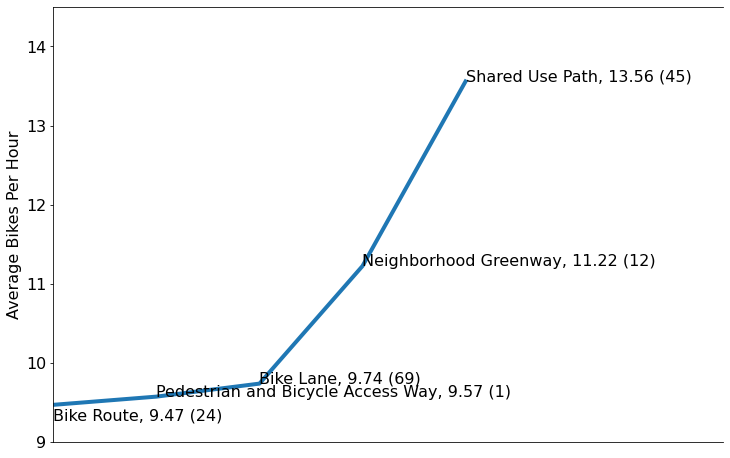

In [41]:
plot_bph(dat=bph_type_1, adjust_label = True)

In [42]:
bph_lane_2 = sj_lane[['BPH', 'Locatin', 'lane_type']].groupby('lane_type').agg({"BPH": np.mean, "Locatin": pd.Series.nunique})

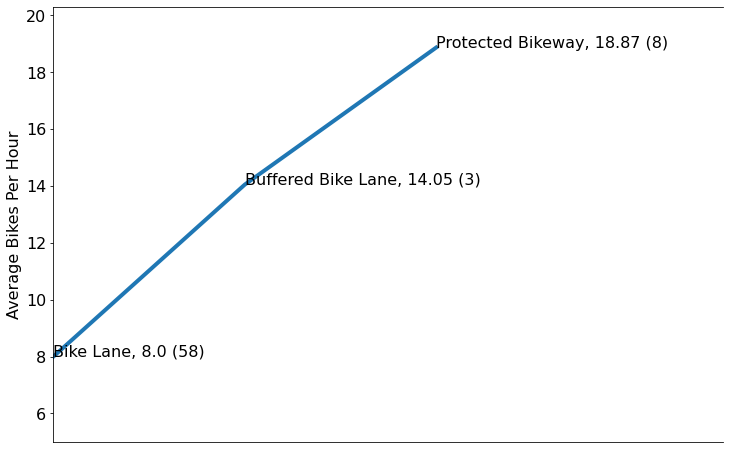

In [43]:
plot_bph(dat=bph_lane_2, x = np.array(range(0,3)), axis_range=[0, 3.5, 5, 20.3], outname="bph_lane_type")

In [44]:
bph_lane_2

,BPH,Locatin
lane_type,,
Bike Lane,8.000488,58
Buffered Bike Lane,14.048335,3
Protected Bikeway,18.868210,8


In [67]:
df = bph_type_1.iloc[1:,:].append(bph_lane_2).sort_values(by=['BPH'], ascending=False)

In [68]:
df.reset_index(inplace=True)

In [69]:
df = df.rename(columns={'index': 'Bike Lane Type', 'BPH': 'Bikes Per Hour', 'Locatin': 'Sampling Size'})

In [70]:
df

,Bike Lane Type,Bikes Per Hour,Sampling Size
0,Protected Bikeway,18.868210,8
1,Buffered Bike Lane,14.048335,3
2,Shared Use Path,13.557319,45
3,Neighborhood Greenway,11.223102,12
4,Pedestrian and Bicycle Access Way,9.571446,1
5,Bike Route,9.467700,24
6,Bike Lane,8.000488,58


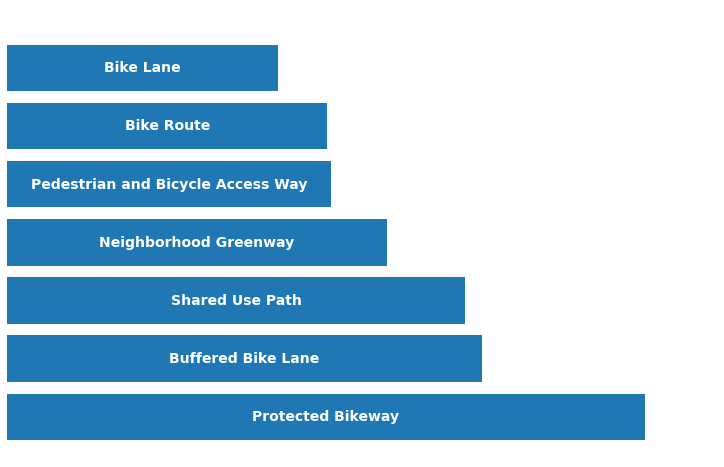

In [116]:
fig, ax = plt.subplots(figsize=(12,8))
g=ax.barh(df['Bike Lane Type'], df['Bikes Per Hour'])
ax.bar_label(g, label_type='center', labels=df['Bike Lane Type'], color='white', fontsize=14.0, fontweight='bold')
ax.bar_label(g, label_type="edge", fmt='%.2f', padding=3, fontsize=14.0, fontweight='bold', color='white')
ax.bar_label(g, label_type="edge", labels= "(" + df['Sampling Size'].astype(str) + ")", padding=50, fontsize=14.0, fontweight='bold', color='white') 
plt.axis('off')
ax.set_title('Bikes per hour by bike lane type (sampling size)', loc='left', fontsize=16, fontweight='bold', color='white')
#plt.show()
plt.savefig(os.path.join(outpath, "BPH_Lane_Type.png"), transparent=False)

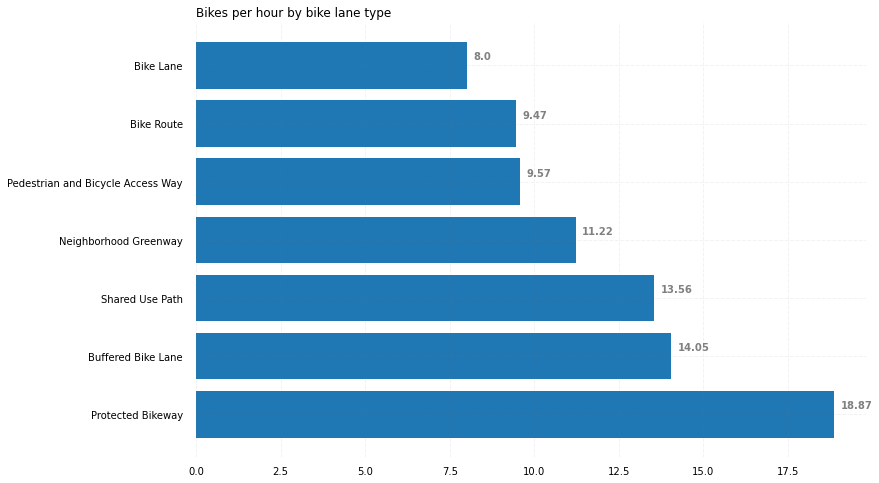

In [73]:
fig, ax = plt.subplots(figsize=(12,8))
ax.barh(df['Bike Lane Type'], df['Bikes Per Hour'])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
#ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold', color='grey')
ax.set_title('Bikes per hour by bike lane type', loc='left')
plt.show()